# Baseline Model

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling   import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc, fbeta_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline

In [15]:
df=pd.read_csv('u5mr_clean.csv')

In [16]:
# Make a safe working copy
df = df.copy()

# Object ID
df['CASEID'] = df['CASEID'].astype('object')

# Continuous floats
float_vars = [
    'Respondents current age',
    'Birth weight in kilograms (3 decimals)',
    'Childs weight in kilograms (1 decimal)',
    'Childs height in centimeters (1 decimal)',
    'Months of breastfeeding',
    'When child put to breast',
    'Height/Age standard deviation (new WHO)',
    'Weight/Age standard deviation (new WHO)',
    'Weight/Height standard deviation (new WHO)'
]
df[float_vars] = df[float_vars].apply(pd.to_numeric, errors="coerce").astype('float64')

# Discrete ints (nullable safe type)
int_vars = [
    'Number of household members (listed)',
    'Birth order number',
    'Preceding birth interval (months)',
    'Succeeding birth interval (months)',
    'Duration of pregnancy in months',
    'Timing of 1st antenatal check (months)',
    'Number of antenatal visits during pregnancy',
    'Entries in pregnancy and postnatal care roster',
    'Minutes to nearest healthcare facility',
    'Number of tetanus injections before birth',
    'Number of tetanus injections before pregnancy'
]
df[int_vars] = df[int_vars].apply(pd.to_numeric, errors="coerce").astype('Int64')

# Categorical (nominal/ordinal)
cat_vars = [
    'Region',
    'Type of place of residence',
    'Highest educational level',
    'Religion',
    'Ethnicity',
    'Wealth index combined',
    'Type of cooking fuel (smoke exposure, indoor air pollution)',
    'Sex of child',
    'Place of delivery',
    'Size of child at birth',
    'Has health card and or other vaccination document',
    'Ever had vaccination',
    'Place where most vaccinations were received',
    'Yellow fever vaccine',
    'Currently breastfeeding',
    'Given child anything other than breast milk',
    'In contact with someone with cough or TB',
    'Source of drinking water',
    'Main floor material',
    'Visited health facility last 12 months',
    'Getting medical help for self: distance to health facility',
    'Mode of transportation to nearest healthcare facility',
]
df[cat_vars] = df[cat_vars].astype('category')

In [17]:
# pattern to drop all columns that end with '_missing' or contain 'vaccine'
leakage_cols = [col for col in df.columns
                if col.endswith('_missing')
                or 'vaccine' in col.lower()
                or 'Received' in col]

# explicitly drop known outcome columns
outcome_cols = [
    'under5_mortality','infant_mortality','neonatal_mortality',
    'mortality_category'
]

In [18]:
leakage_cols

['Received BCG',
 'Received DPT 3',
 'Received POLIO 3',
 'Received MEASLES 2',
 'Received inactivated polio (IPV)',
 'Yellow fever vaccine',
 'Preceding birth interval (months)_missing',
 'Succeeding birth interval (months)_missing',
 'Timing of 1st antenatal check (months)_missing',
 'Number of antenatal visits during pregnancy_missing',
 'Birth weight in kilograms (3 decimals)_missing',
 'Ever had vaccination_missing',
 'Months of breastfeeding_missing',
 'When child put to breast_missing',
 'Minutes to nearest healthcare facility_missing',
 'Number of tetanus injections before birth_missing',
 'Number of tetanus injections before pregnancy_missing',
 'Place of delivery_missing',
 'Size of child at birth_missing',
 'Prenatal: doctor_missing',
 'Prenatal: nurse/midwife/clinical officer_missing',
 'Prenatal: traditional birth attendant_missing',
 'Prenatal: Community health worker/field worker_missing',
 'Has health card and or other vaccination document_missing',
 'Received BCG_missi

In [19]:
X = df.drop(columns=leakage_cols + outcome_cols + ['CASEID'])

In [20]:
corr = X.corr(numeric_only=True).abs()
high_corr = np.where(corr > 0.9)
pairs = [(corr.index[i], corr.columns[j])
         for i,j in zip(*high_corr)
         if i < j]
print(pairs)

[('Childs weight in kilograms (1 decimal)', 'Childs height in centimeters (1 decimal)')]


In [21]:
# create BMI column
df['child_BMI'] = df['Childs weight in kilograms (1 decimal)'] / (
    (df['Childs height in centimeters (1 decimal)'] / 100) ** 2
)

# drop originals to avoid multicollinearity
df = df.drop(columns=[
    'Childs weight in kilograms (1 decimal)',
    'Childs height in centimeters (1 decimal)'
])
df['child_BMI'] = df['child_BMI'].round(2)

In [22]:
cat_cols = X.select_dtypes(include=['object','category']).columns
num_cols = X.select_dtypes(exclude=['object','category']).columns

In [23]:

cat_cols

Index(['Region', 'Type of place of residence', 'Highest educational level',
       'Religion', 'Ethnicity', 'Wealth index combined',
       'Type of cooking fuel (smoke exposure, indoor air pollution)',
       'Sex of child', 'Place of delivery', 'Size of child at birth',
       'Has health card and or other vaccination document',
       'Ever had vaccination', 'Place where most vaccinations were received',
       'Currently breastfeeding',
       'Given child anything other than breast milk',
       'In contact with someone with cough or TB', 'Source of drinking water',
       'Main floor material', 'Visited health facility last 12 months',
       'Getting medical help for self: distance to health facility',
       'Mode of transportation to nearest healthcare facility'],
      dtype='object')

In [24]:
df.info(50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19530 entries, 0 to 19529
Data columns (total 93 columns):
 #   Column                                                              Non-Null Count  Dtype   
---  ------                                                              --------------  -----   
 0   CASEID                                                              19530 non-null  object  
 1   Respondents current age                                             19530 non-null  float64 
 2   Region                                                              19530 non-null  category
 3   Type of place of residence                                          19530 non-null  category
 4   Highest educational level                                           19530 non-null  category
 5   Religion                                                            19530 non-null  category
 6   Ethnicity                                                           19530 non-null  category
 7   Numb

In [25]:
# Preprocessing: scale numeric + one-hot encode categoricals
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

baseline_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [31]:
def baseline_logistic(X, y, target_name):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Fit baseline model
    baseline_pipe.fit(X_train, y_train)

    # Predictions
    y_pred  = baseline_pipe.predict(X_test)
    y_proba = baseline_pipe.predict_proba(X_test)[:, 1]  # for AUC metrics

    # --- Evaluation ---
    print(f"\n--- Baseline Logistic Regression: {target_name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(classification_report(y_test, y_pred, digits=3))

    # F2 score
    f2 = fbeta_score(y_test, y_pred, beta=2)
    print(f"F2 Score: {f2:.3f}")

    # ROC-AUC
    roc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {roc:.3f}")

    # Precision–Recall AUC
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC: {pr_auc:.3f}")

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0','Pred 1'],
                yticklabels=['True 0','True 1'])
    plt.title(f"Confusion Matrix: {target_name}")
    plt.show()


--- Baseline Logistic Regression: Under-5 Mortality ---
Accuracy: 0.978
              precision    recall  f1-score   support

           0      0.987     0.990     0.989      3767
           1      0.709     0.647     0.677       139

    accuracy                          0.978      3906
   macro avg      0.848     0.819     0.833      3906
weighted avg      0.977     0.978     0.978      3906

F2 Score: 0.659
ROC-AUC: 0.988
PR-AUC: 0.736


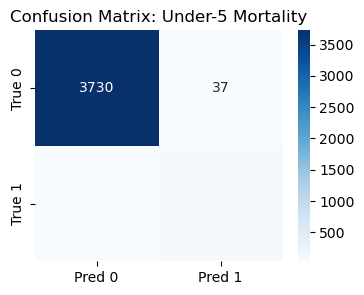


--- Baseline Logistic Regression: Infant Mortality ---
Accuracy: 0.990
              precision    recall  f1-score   support

           0      0.991     0.998     0.995      3870
           1      0.143     0.028     0.047        36

    accuracy                          0.990      3906
   macro avg      0.567     0.513     0.521      3906
weighted avg      0.983     0.990     0.986      3906

F2 Score: 0.033
ROC-AUC: 0.971
PR-AUC: 0.194


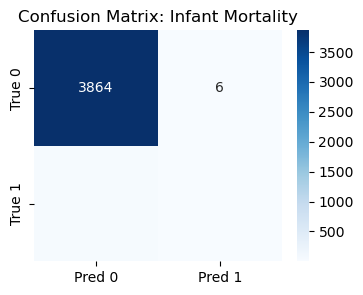


--- Baseline Logistic Regression: Neonatal Mortality ---
Accuracy: 0.984
              precision    recall  f1-score   support

           0      0.988     0.997     0.992      3819
           1      0.750     0.448     0.561        87

    accuracy                          0.984      3906
   macro avg      0.869     0.722     0.777      3906
weighted avg      0.982     0.984     0.982      3906

F2 Score: 0.488
ROC-AUC: 0.984
PR-AUC: 0.647


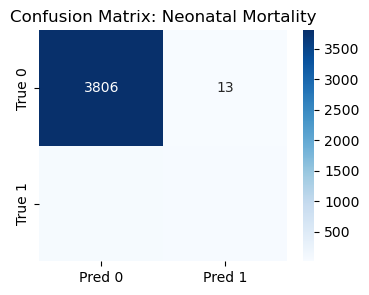

In [34]:
baseline_logistic(X, df['under5_mortality'], 'Under-5 Mortality')
baseline_logistic(X, df['infant_mortality'], 'Infant Mortality')
baseline_logistic(X, df['neonatal_mortality'], 'Neonatal Mortality')

## Logistic Regression with SMOTE

In [35]:
smote_pipe = Pipeline([
    ('preprocessor', preprocessor),      # <--- reuse the preprocessor you just built
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [36]:
from sklearn.metrics import average_precision_score
def logistic_with_smote(X, y, name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    smote_pipe.fit(X_train, y_train)
    y_pred = smote_pipe.predict(X_test)
    y_prob = smote_pipe.predict_proba(X_test)[:, 1]   # probabilities for ROC/PR

    print(f"\n--- Logistic Regression + SMOTE : {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print("PR-AUC:", average_precision_score(y_test, y_prob))

In [37]:
# Run for each target
logistic_with_smote(X, df['under5_mortality'], 'Under-5 Mortality')
logistic_with_smote(X, df['infant_mortality'], 'Infant Mortality')
logistic_with_smote(X, df['neonatal_mortality'], 'Neonatal Mortality')


--- Logistic Regression + SMOTE : Under-5 Mortality ---
Accuracy: 0.9572452636968766
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3767
           1       0.45      0.96      0.61       139

    accuracy                           0.96      3906
   macro avg       0.73      0.96      0.80      3906
weighted avg       0.98      0.96      0.96      3906

F2 Score: 0.7823529411764705
ROC-AUC: 0.9878402560669809
PR-AUC: 0.6954850228413343

--- Logistic Regression + SMOTE : Infant Mortality ---
Accuracy: 0.9544290834613415
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3870
           1       0.13      0.67      0.21        36

    accuracy                           0.95      3906
   macro avg       0.56      0.81      0.59      3906
weighted avg       0.99      0.95      0.97      3906

F2 Score: 0.35928143712574845
ROC-AUC: 0.9675208153890326
PR-AUC: 0.16571822778971562

--- 

In [40]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import  make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [41]:
# --- Custom scorers focused on death detection ---
def pr_auc_score(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    return auc(recall, precision)

f2_scorer   = make_scorer(fbeta_score, beta=2)
pr_auc_scorer = make_scorer(pr_auc_score, needs_proba=True)

In [42]:
# --- Cross-validation setup ---
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- Base pipeline with SMOTE inside ---
base_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, k_neighbors=1)),  # k_neighbors=1 handles very small minority counts
    ('model', RandomForestClassifier())               # placeholder; will be overridden by param grid
])

In [43]:
# --- Parameter grid for three algorithms ---
param_grid = [
    # Random Forest
    {
        'model': [RandomForestClassifier(random_state=42)],
        'model__n_estimators': [100, 300],
        'model__max_depth': [None, 10]
    },
    # Gradient Boosting
    {
        'model': [GradientBoostingClassifier(random_state=42)],
        'model__n_estimators': [100, 300],
        'model__learning_rate': [0.1, 0.05],
        'model__max_depth': [3, 5]
    },
    # XGBoost
    {
        'model': [XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1
        )],
        'model__n_estimators': [200, 400],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.1, 0.05]
    }
]

In [44]:
# --- Grid search ---
grid = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring={'F2': f2_scorer, 'PR-AUC': pr_auc_scorer},
    refit='F2',        # best model chosen by F2
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [45]:
# === Function to train & evaluate for one target ===
def train_eval_model(X, y, target_name):
    grid.fit(X, y)

    print(f"\n--- Best model for {target_name} ---")
    print("Estimator:", grid.best_estimator_['model'])
    print("Best F2:", grid.best_score_)

    # Evaluate on the hold-out folds already done in CV
    # For a final external test set, split beforehand and call grid.score(X_test, y_test)

    y_pred = grid.predict(X)
    y_prob = grid.predict_proba(X)[:, 1]

    print("\nClassification Report:")
    print(classification_report(y, y_pred, digits=3))
    print("Accuracy:", accuracy_score(y, y_pred))
    print("ROC-AUC:", roc_auc_score(y, y_prob))
    precision, recall, _ = precision_recall_curve(y, y_prob)
    print("PR-AUC:", auc(recall, precision))

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0','Pred 1'],
                yticklabels=['True 0','True 1'])
    plt.title(f"Confusion Matrix: {target_name}")
    plt.show()

Fitting 3 folds for each of 20 candidates, totalling 60 fits

--- Best model for Under-5 Mortality ---
Estimator: RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42)
Best F2: 0.9802414804622938

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.996     0.998     18836
           1      0.898     1.000     0.946       694

    accuracy                          0.996     19530
   macro avg      0.949     0.998     0.972     19530
weighted avg      0.996     0.996     0.996     19530

Accuracy: 0.9959549411162314
ROC-AUC: 0.9993503763410918
PR-AUC: 0.9767483465666057


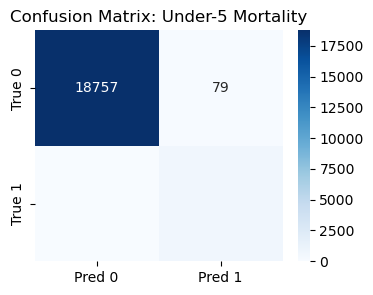

Fitting 3 folds for each of 20 candidates, totalling 60 fits

--- Best model for Infant Mortality ---
Estimator: GradientBoostingClassifier(learning_rate=0.05, random_state=42)
Best F2: 0.6451675421893542

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.977     0.988     19350
           1      0.286     0.983     0.444       180

    accuracy                          0.977     19530
   macro avg      0.643     0.980     0.716     19530
weighted avg      0.993     0.977     0.983     19530

Accuracy: 0.9772657450076805
ROC-AUC: 0.9916511627906976
PR-AUC: 0.45401158057103747


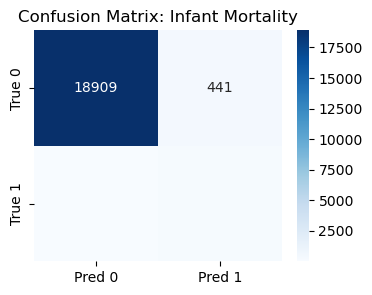

Fitting 3 folds for each of 20 candidates, totalling 60 fits

--- Best model for Neonatal Mortality ---
Estimator: RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42)
Best F2: 0.8689379566170156

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.983     0.991     19093
           1      0.575     1.000     0.730       437

    accuracy                          0.983     19530
   macro avg      0.787     0.992     0.861     19530
weighted avg      0.990     0.983     0.986     19530

Accuracy: 0.9834613415258576
ROC-AUC: 0.997776030871894
PR-AUC: 0.901284111205658


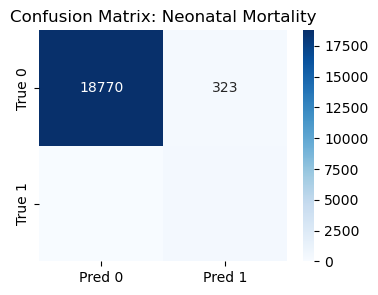

In [46]:
train_eval_model(X, df['under5_mortality'], 'Under-5 Mortality')
train_eval_model(X, df['infant_mortality'], 'Infant Mortality')
train_eval_model(X, df['neonatal_mortality'], 'Neonatal Mortality')